In [1]:
import tensorflow as tf   # library for ai and ml . it has particular focus on training and interference of deep neural network
from tensorflow.keras import models,layers #model group layers into an object with training and interference features
import matplotlib.pyplot as plt # to plot graphs (plotting library)

In [2]:
Image_Size=256  # each image size
Batch_Size=32  #batch size (total images are divided into 32 batches)
EPOCHS=30 #An epoch is when all the training data is used at once and is defined as the total number of iterations 
#of all the training data in one cycle for training the machine learning model. 
Channels=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("Plant Village",shuffle=True,image_size=(Image_Size,Image_Size),batch_size=Batch_Size)

Found 39134 files belonging to 21 classes.


In [4]:
class_names=dataset.class_names #class names are stored in class_names

In [5]:
class_names #class names are given

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
len(class_names) #no of class names 

21

In [7]:
len(dataset) # length of dataset which is divided into 32 batches

1223

In [8]:
574*32 #this is why 32*574 gives total no of files or images

18368

In [9]:
for image_batch, label_batch in dataset.take(1): # it gives 1 batch of size 32
    print(label_batch[0].numpy()) 
    print(image_batch[0].shape)    # rgb value of 1st images with dimension3  

5
(256, 256, 3)


In [10]:
for image_batch, label_batch in dataset.take(1): # it gives 1 batch of size 32
    print(label_batch.numpy()) 
    print(image_batch.shape)

[15 16  2 19 19 14  0 16  3  4  4  0 18 14 10  2 20 12  8  6  9  2  1  5
  4  4 16  8 20 10  7  3]
(32, 256, 256, 3)


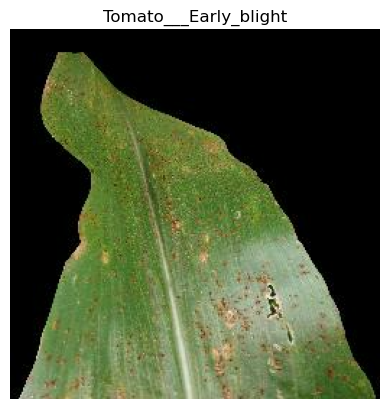

In [11]:
for image_batch, label_batch in dataset.take(1): # it gives 1 batch of size 32
#   plt.imshow(image_batch[0].numpy()) print image from float values
    plt.imshow(image_batch[0].numpy().astype("uint8")) #converted to int
    plt.axis("off") #hides axis from the image
    plt.title(class_names[label_batch[1]]) #defines class name

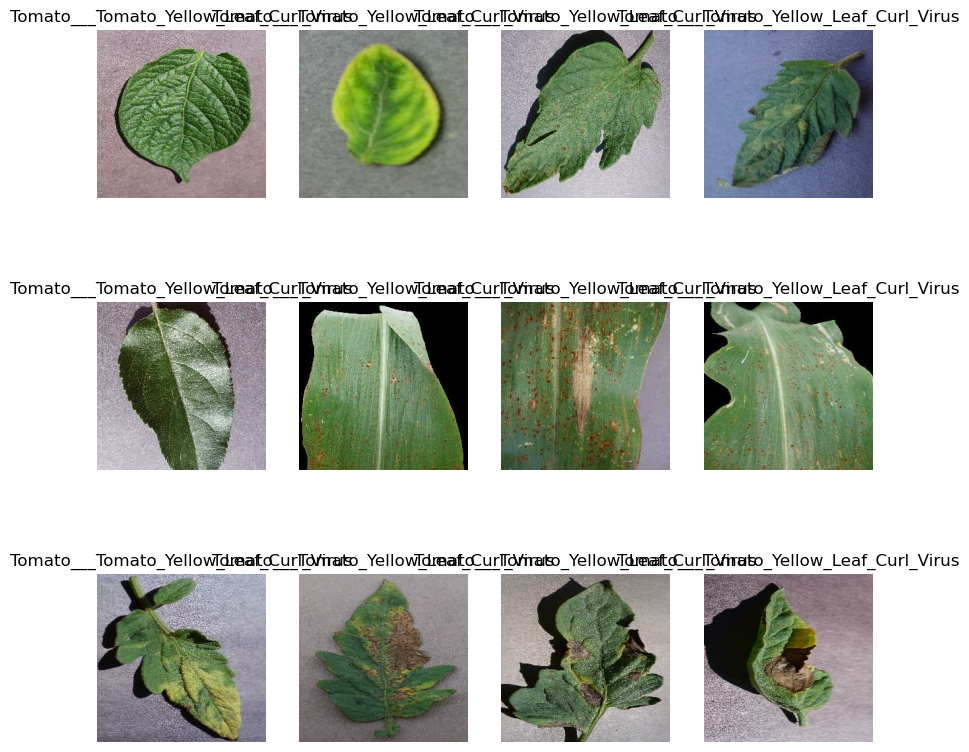

In [12]:
plt.figure(figsize=(10,10)) #size the figure
for image_batch, label_batch in dataset.take(1): # it gives 1 batch of size 32
    for i in range(12):
        ax=plt.subplot(3,4,i+1) #it gives the no of rows and cols in which image will be shown and i will be incremented
        plt.imshow(image_batch[i].numpy().astype("uint8")) #converted to int
        plt.axis("off") #hides axis from the image
        plt.title(class_names[label_batch[1]]) #defines class name

In [13]:
#80% training
#10% validate
#10% test

In [14]:
#train test split
train_size=0.8 #Since train size is 80%
len(dataset)*train_size #taking 80% of dataset

978.4000000000001

In [15]:
train_ds=dataset.take(978) #taking starting 459 as train dataset
len(train_ds) #length of train dataset

978

In [16]:
test_ds=dataset.skip(978) #skipping train dataset and taking left dataset as test dataset
len(test_ds) #length of test dataset 

245

In [17]:
val_size=0.1 #now taking validate dataset from test dataset
len(dataset)*val_size #0.1 of dataset

122.30000000000001

In [18]:
val_ds=test_ds.take(122) #now taking validate dataset as 57 images from test dataset
len(val_ds) #length of validate dataset

122

In [19]:
test_ds=test_ds.skip(122)  # now taking test dataet by skipping previous test dataset
len(test_ds) #length of test dataset

123

In [20]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000): #making a function to find train,validatae,test dataset
    ds_size=len(ds)             #taking length of dataset
    if shuffle:             #if shuffle is true
        ds=ds.shuffle(shuffle_size,seed=12) #shuffling the dataset
    train_size=int(train_split*ds_size)  #finding the size of train dataset
    val_size=int(val_split*ds_size)  #finding the size of validate dataset 
    train_ds=ds.take(train_size) #finding the train dataset
    val_ds=ds.skip(train_size).take(val_size) #finding the validate dataset
    test_ds=ds.skip(train_size).take(val_size) #finding the test dataset
    return train_ds,val_ds,test_ds #returning all the datasets

In [21]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset) #calling the function and getting the data in train,validate,test dataset

In [22]:
len(train_ds) #finding the length of train

978

In [23]:
len(val_ds)#finding the length of validation dataset

122

In [24]:
len(test_ds)#finding the length of test dataset

122

In [25]:
#cache function will keep the image in the memory so that if called again during next epoch it will remain in memory so that it can be used again
#shuffle will shuffle the images 
#if GPU is busy in training then prefetch will call CPU to fetch next set of images and thus improves the performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#buffersize will be how many batches will be load 
val_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale =tf.keras.Sequential([layers.experimental.preprocessing.Resizing(Image_Size,Image_Size), #it will resize our image if image is not of size 256,256
                    layers.experimental.preprocessing.Rescaling(1.0/255)])#previously the image was in rgb scale 0-255 so we are changing its scale between 0 and 1

In [27]:
#data augmentation to make our model robust 
#if the image is rotated and not in contrast then it will help to predict the image 
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU, PReLU, LeakyReLU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as layers

In [40]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)

model = keras.Sequential(
    [
    resize_and_rescale, #1st layer
    data_augmentation, #2nd layer
    ]
)
model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", 
                        input_shape=(256, 256, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(21, activation="softmax"))#softmax will normalize the probability of classes

In [46]:
model.build(input_shape=input_shape)
model.summary() #print model summary

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           multiple                  34944     
_________________________________________________________________
batch_normalization_10 (Batc multiple                  384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_11 (Conv2D)           multiple                  614656    
_________________________________________________________________
batch_normalization_11 (Batc multiple                 

In [47]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
scores = model.evaluate(test_ds)

978/978 [==============================] - 490s 426ms/step - loss: 3.0440 - accuracy: 0.0432


In [ ]:
#history to track the accuracy 
#first loss and accuracy is of train dataset and second loss and accuracy is of test dataset

In [48]:
# fit the model
#fit_generator(object, generator, steps_per_epoch, epochs = 1,
#verbose = getOption("keras.fit_verbose", default = 1),
#callbacks = NULL, view_metrics = getOption("keras.view_metrics",
#default = "auto"), validation_data = NULL, validation_steps = NULL,
#class_weight = NULL, max_queue_size = 10, workers = 1,
#initial_epoch = 0)

#model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches,
          #validation_steps=len(valid_batches), epochs=10, verbose=1 )
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
978/978 [==============================] - 2148s 2s/step - loss: 3.4202 - accuracy: 0.4400 - val_loss: 3.6681 - val_accuracy: 0.3181
Epoch 2/30
978/978 [==============================] - 1940s 2s/step - loss: 1.0429 - accuracy: 0.6732 - val_loss: 2.5909 - val_accuracy: 0.4520
Epoch 3/30
978/978 [==============================] - 1916s 2s/step - loss: 0.7757 - accuracy: 0.7571 - val_loss: 1.4146 - val_accuracy: 0.6132
Epoch 4/30
978/978 [==============================] - 1919s 2s/step - loss: 0.5832 - accuracy: 0.8121 - val_loss: 0.4135 - val_accuracy: 0.8695
Epoch 5/30
978/978 [==============================] - 1894s 2s/step - loss: 0.4764 - accuracy: 0.8462 - val_loss: 3.5450 - val_accuracy: 0.3886
Epoch 6/30
978/978 [==============================] - 1909s 2s/step - loss: 0.4016 - accuracy: 0.8744 - val_loss: 0.9300 - val_accuracy: 0.7224
Epoch 7/30
978/978 [==============================] - 1884s 2s/step - loss: 0.3608 - accuracy: 0.8878 - val_loss: 0.2701 - val_accuracy:

KeyboardInterrupt: 

In [49]:
scores = model.evaluate(test_ds) #for first time we are trying this alexnet model on test dataset which was not feed previously

459/459 [==============================] - 111s 242ms/step - loss: 0.7004 - accuracy: 0.8426


In [50]:
scores #it will print the whole loss and accuracy on test dataset

[0.7003905177116394, 0.842618465423584]

In [51]:
history

In [52]:
history.params #the parameters of history

{'verbose': 1, 'epochs': 30, 'steps': 459}

In [53]:
history.history.keys() #four key values 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
acc = history.history['accuracy'] #all train accuracy values arae stored in this acc
val_acc = history.history['val_accuracy'] #all validation accuracy values arae stored in this acc

loss = history.history['loss'] #all train dataset loss values arae stored in this acc
val_loss = history.history['val_loss'] #all validation accuracy values arae stored in this acc

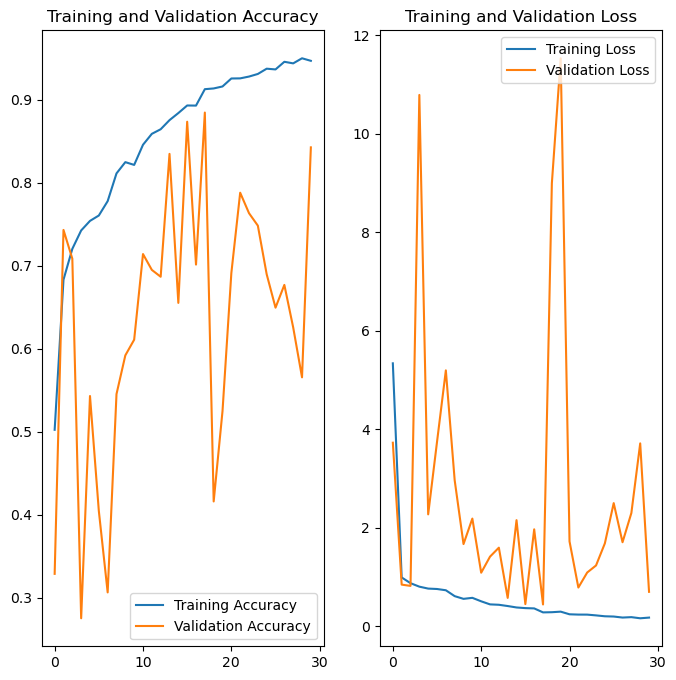

In [55]:
plt.figure(figsize=(8,8))# Plotting a figure of width 8 and height 8
plt.subplot(1,2,1) #the figure has 1 row, 2 columns and this plot is the first plot.
plt.plot(range(EPOCHS), acc, label='Training Accuracy') #plotting the training accuracy with epochs on x-axis and acc on y-axis and labelling the graph as "Training Accuracy"
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy') #plotting the validation accuracy with epochs on x-axis and val_acc on y-axis and labelling the graph as "Validation Accuracy"
plt.legend(loc='lower right') #it is used to describe the area and location it will be shown 
plt.title('Training and Validation Accuracy')  #giving the title to the graph 

plt.subplot(1, 2, 2) #the figure has 1 row, 2 columns and this plot is the second plot.
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right') #it is used to describe the area and location it will be shown 
plt.title('Training and Validation Loss')  #giving the title to the graph 
plt.show()

first image to predict
First image's actual label:  Tomato___healthy
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___healthy


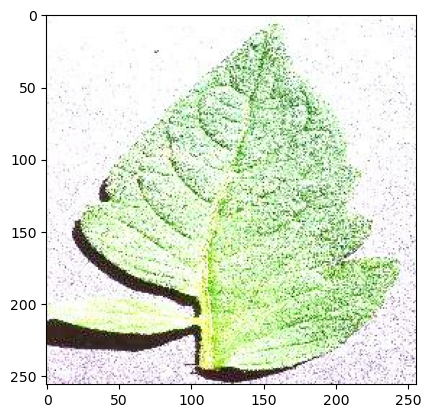

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1): #taking first batch of 32 images
    first_image = images_batch[0].numpy().astype('uint8') # to get the first image of batch 0 as array
    first_label = labels_batch[0].numpy() #first label

    print("first image to predict")
    plt.imshow(first_image) #to print image in the form of graph 
    print("First image's actual label: ",class_names[first_label]) # actual label index=first label and class name is printed

    batch_prediction = model.predict(images_batch) #predicted whole 1st image batch
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) #argmax returns the index of maximum number and printing the 
    #class name of the predicted disease

In [57]:
def predict(model, img): #making prediction function in which we are passing the model and image
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())     #converting image to array and preprocessing it
    img_array = tf.expand_dims(img_array, 0) #creating a batch out of img_array

    predictions = model.predict(img_array)  #then model is predicting that batch and storing in predictions

    predicted_class = class_names[np.argmax(predictions[0])]  #argmax returns the index of maximum number and printing the 
    #class name of the predicted disease
    confidence = round(100 * (np.max(predictions[0])), 2) #calculating the confidence
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


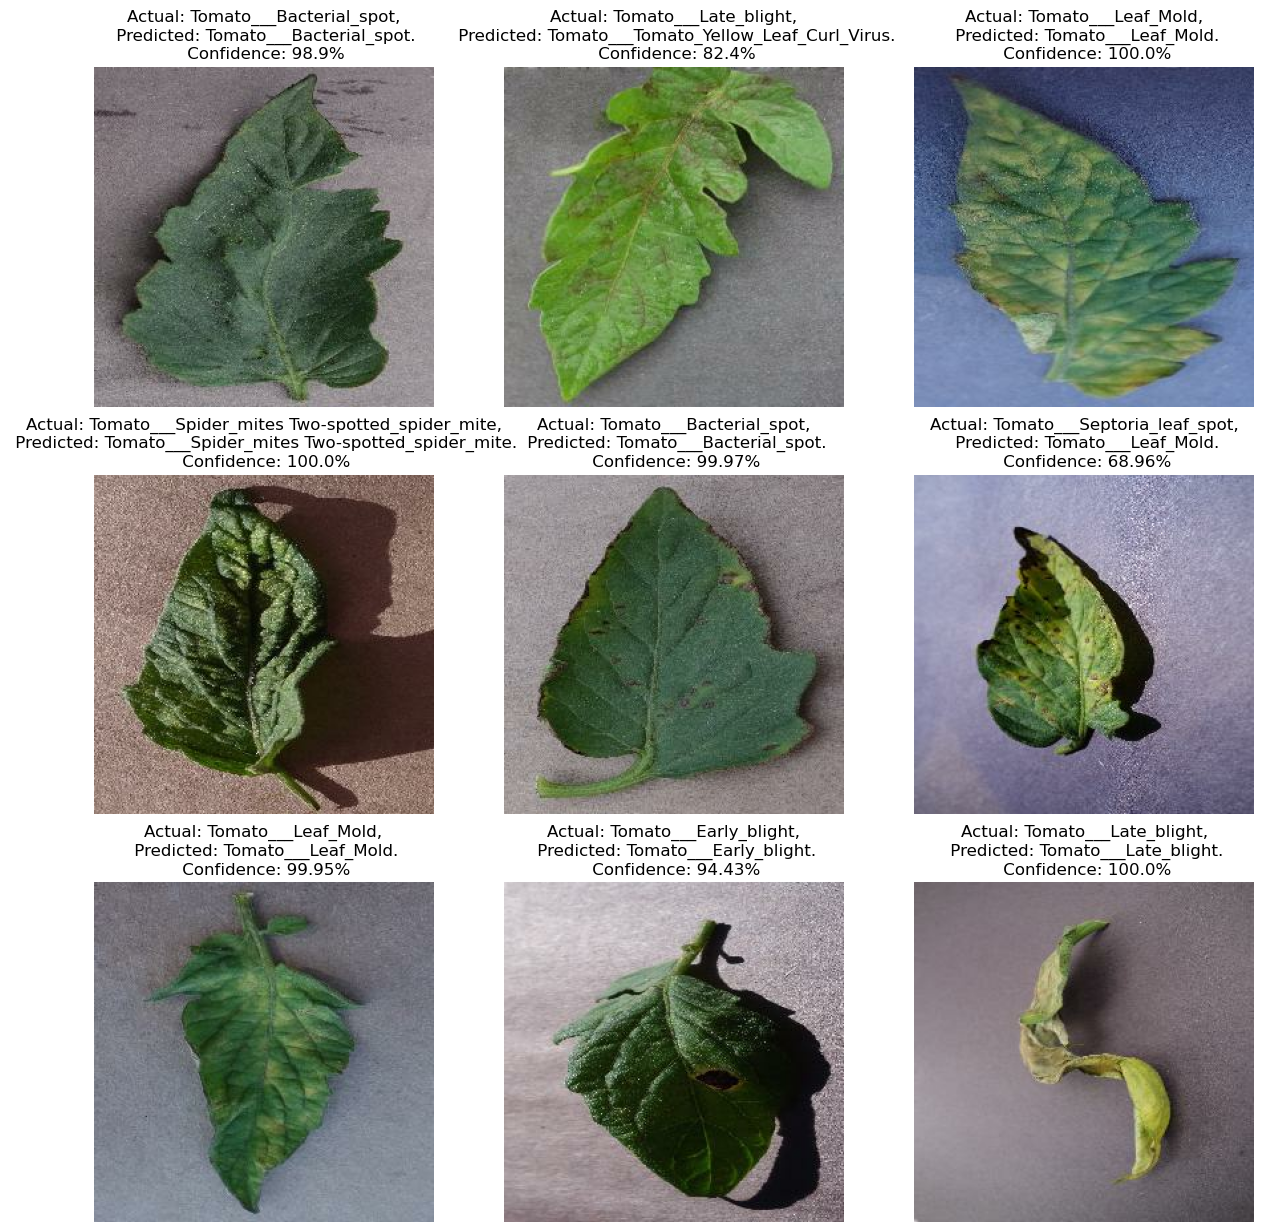

In [59]:
plt.figure(figsize=(15, 15))  #plotting the figure
for images, labels in test_ds.take(1):  #taking first batch of image test dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)    #dividing the figure in subplot
        plt.imshow(images[i].numpy().astype("uint8")) #showing the array image in image format
        
        predicted_class, confidence = predict(model, images[i].numpy()) #calling the predict function
        actual_class = class_names[labels[i]]  
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") #printing the actual label 
        #predicted label and confidence label
        
        plt.axis("off")

In [62]:
import os
model_version=max([int(i) for i in os.listdir("C:/Users/hp/Documents/Project/tomato-disease/training/models") + [0]])+1
model.save(f"C:/Users/hp/Documents/Project/tomato-disease/training/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/hp/Documents/Project/tomato-disease/training/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/hp/Documents/Project/tomato-disease/training/models/1\assets
